## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [9]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import train_test_split

from generate_design_matrix import DesignMatrixGenerator, ExpFilter
from get_rat_data import *
from multiclass_logistic_regression import MultiClassLogisticRegression
from sigma_tau_search_experiment import SigmaTauSearchExperiment
from method_validation import plot_kernel_validation

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Apply exp filter on session by session basis

In [2]:
# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)
session_boundaries_mask = df["session"].diff() == 0

df["prev_violation"] = (df.violation.shift() * session_boundaries_mask).fillna(0)

tau = 3
filter_obj = ExpFilter(tau=tau, column="prev_violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: prev_violation, Tau: 3
Exp filter added for session 2 | Column: prev_violation, Tau: 3
Exp filter added for session 3 | Column: prev_violation, Tau: 3


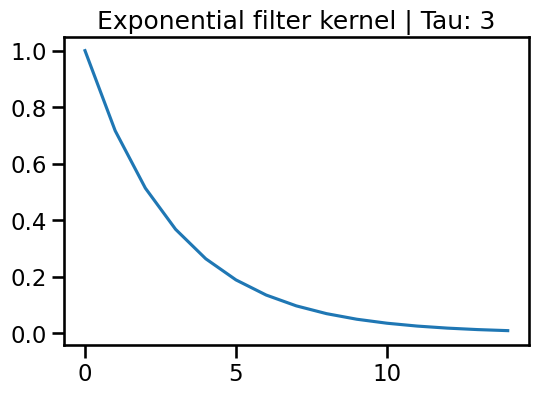

In [3]:
filter_obj.plot_kernel()

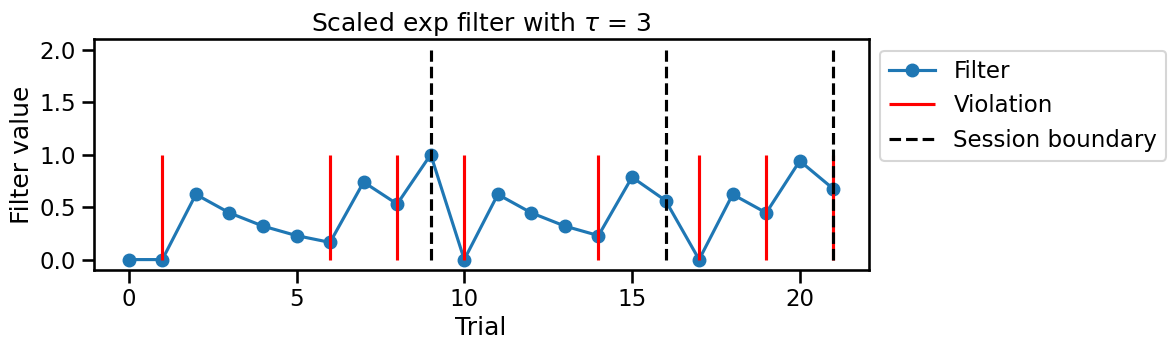

In [4]:
plot_kernel_validation(df, f"prev_violation_exp_{tau}")

TODO: 
[ ] make trained/not df

[ ] edit code to run for all animals if None?

[ ] run sweep across all sigmas/taus



In [45]:
params = {
    "animals": None,
    "sigmas": [0, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 3, 5],
    "taus": [0, 1, 2, 3, 5, 7, 9, 12, 15, 18, 20, 25, 30],
    "random_state": 44,
    "test_size": 0.25,
}

full_experiment = SigmaTauSearchExperiment(params)
results = full_experiment.run()

returning dataset for all animals
evaluating animal W051
Optimization terminated successfully.
         Current function value: 521124.936202
         Iterations: 24
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: 504953.659937
         Iterations: 23
         Function evaluations: 87
         Gradient evaluations: 76
         Current function value: 494995.510783
         Iterations: 24
         Function evaluations: 119
         Gradient evaluations: 107
         Current function value: 491980.990043
         Iterations: 25
         Function evaluations: 82
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: 491957.318691
         Iterations: 26
         Function evaluations: 36
         Gradient evaluations: 36
         Current function value: 494124.499099
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33
         Current function value

In [46]:
full_experiment.animals

array(['W051', 'W060', 'W061', 'W062', 'W065', 'W066', 'W068', 'W072',
       'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083',
       'W088', 'W089', 'W094'], dtype=object)

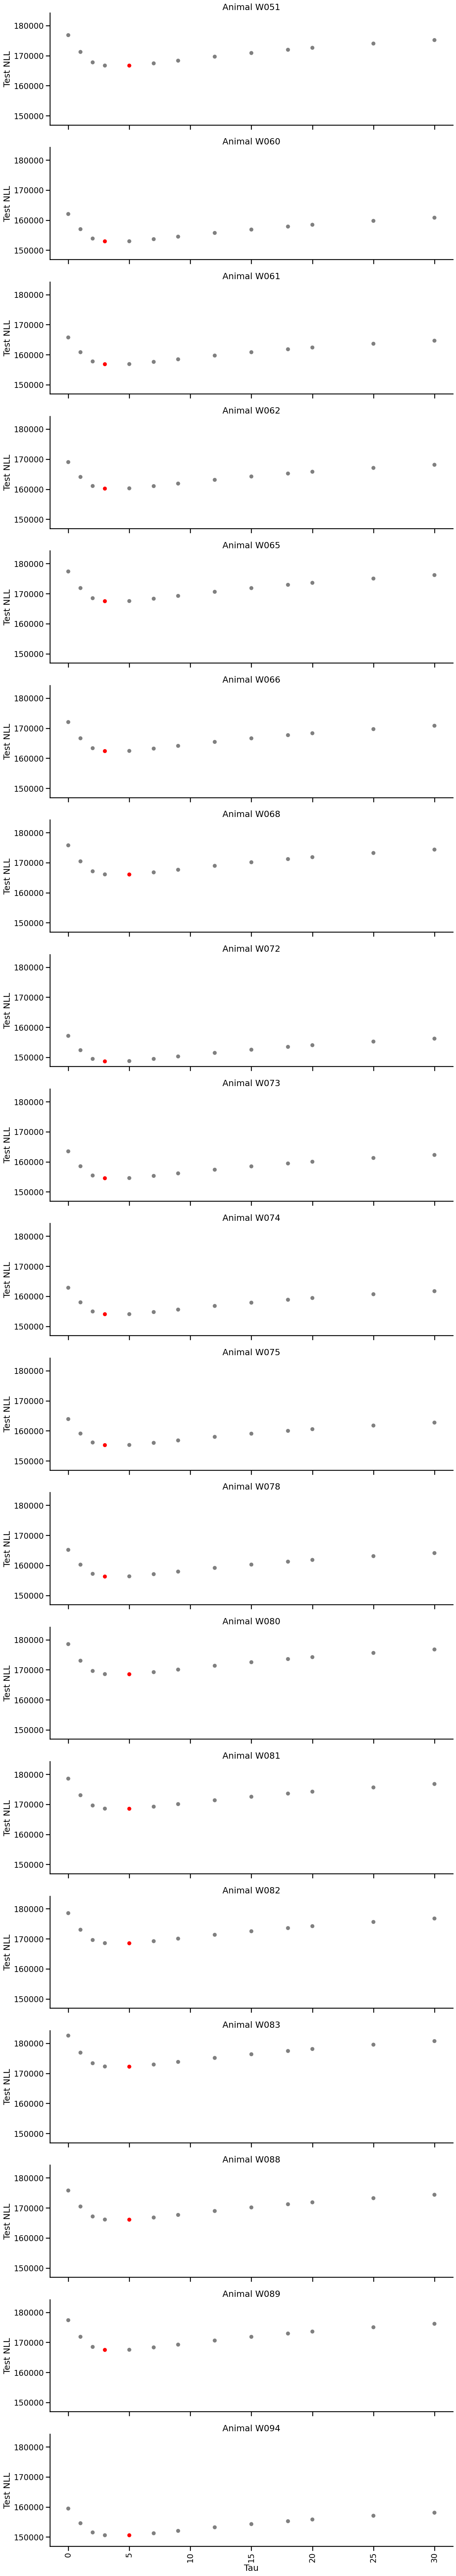

In [47]:
full_experiment.plot_nll_over_taus()

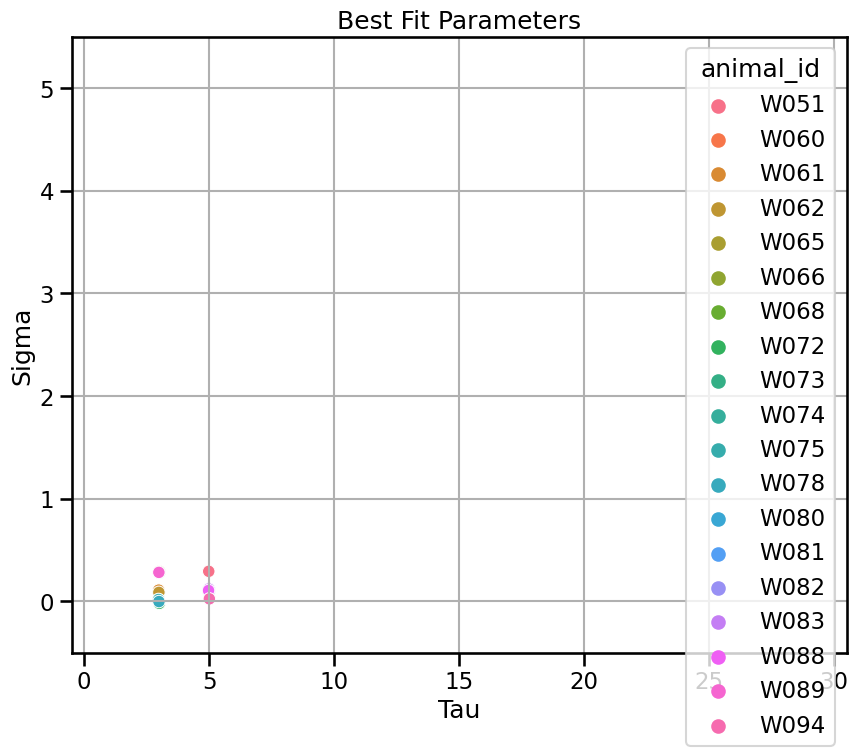

In [48]:
full_experiment.plot_best_sigma_tau_by_animal(jitter=0.025)

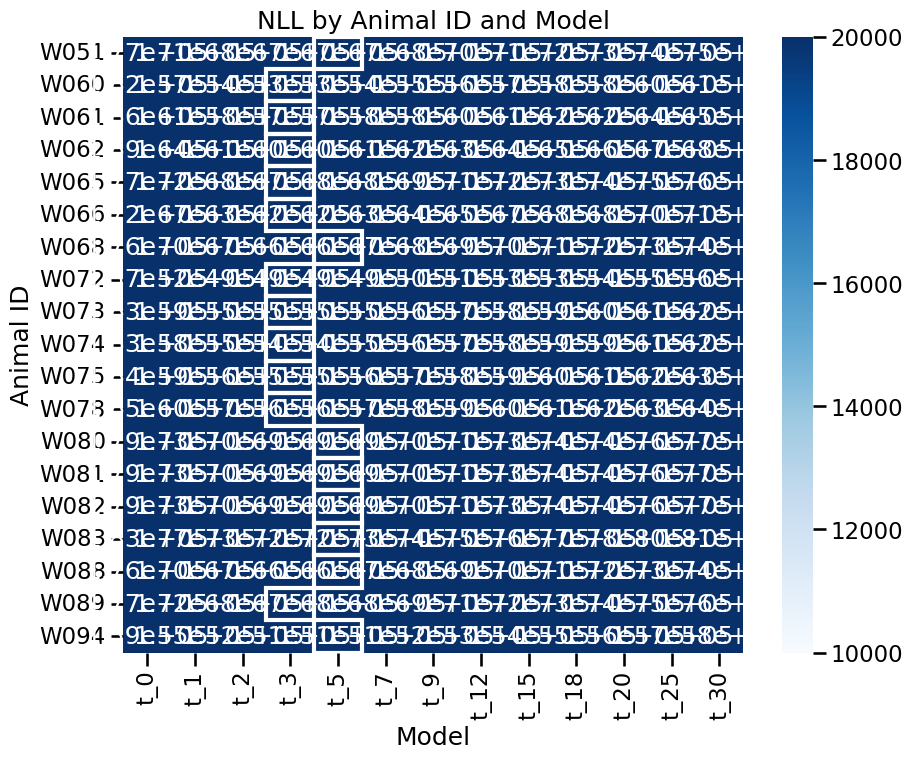

In [49]:
full_experiment.plot_tau_heatmap()

In [57]:
res_path = pathlib.Path("Users/jessbreda/Desktop/github/animal-learning/data/results/")

In [63]:
(res_path / "macro_sweep.csv")

PosixPath('Users/jessbreda/Desktop/github/animal-learning/data/results/macro_sweep.csv')

In [65]:
results.to_csv("macro_sweep.csv", index=False)

In [66]:
results

,animal_id,model_name,nll,sigma,tau,features,weights
0,W051,t_0,176809.140837,0.0,0,"[bias, prev_violation, s_a, s_b, prev_sound_av...","[[0.2502722636959583, 0.25145767689309545, -0...."
1,W051,t_1,171218.595621,0.0,1,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.35068860956035314, 0.3529254370541131, -0...."
2,W051,t_2,167746.205942,0.0,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.42853377974283874, 0.43127969686498024, -0..."
3,W051,t_3,166690.026397,0.0,3,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.46555154954144445, 0.46788197773989404, -0..."
4,W051,t_5,166673.958319,0.0,5,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.4991816865512872, 0.49946652664789765, -0...."
...,...,...,...,...,...,...,...
2218,W094,t_15,154298.765752,5.0,15,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.5211495535659145, 0.5211496593263648, -1.0..."
2219,W094,t_18,155255.272451,5.0,18,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.5210882193916268, 0.5186210357932076, -1.0..."
2220,W094,t_20,155829.206557,5.0,20,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.5207572919059132, 0.5167026392876276, -1.0..."
2221,W094,t_25,157074.937749,5.0,25,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.5195422011848113, 0.5118862786161886, -1.0..."


In [ ]:
full_experiment.results.write_csv

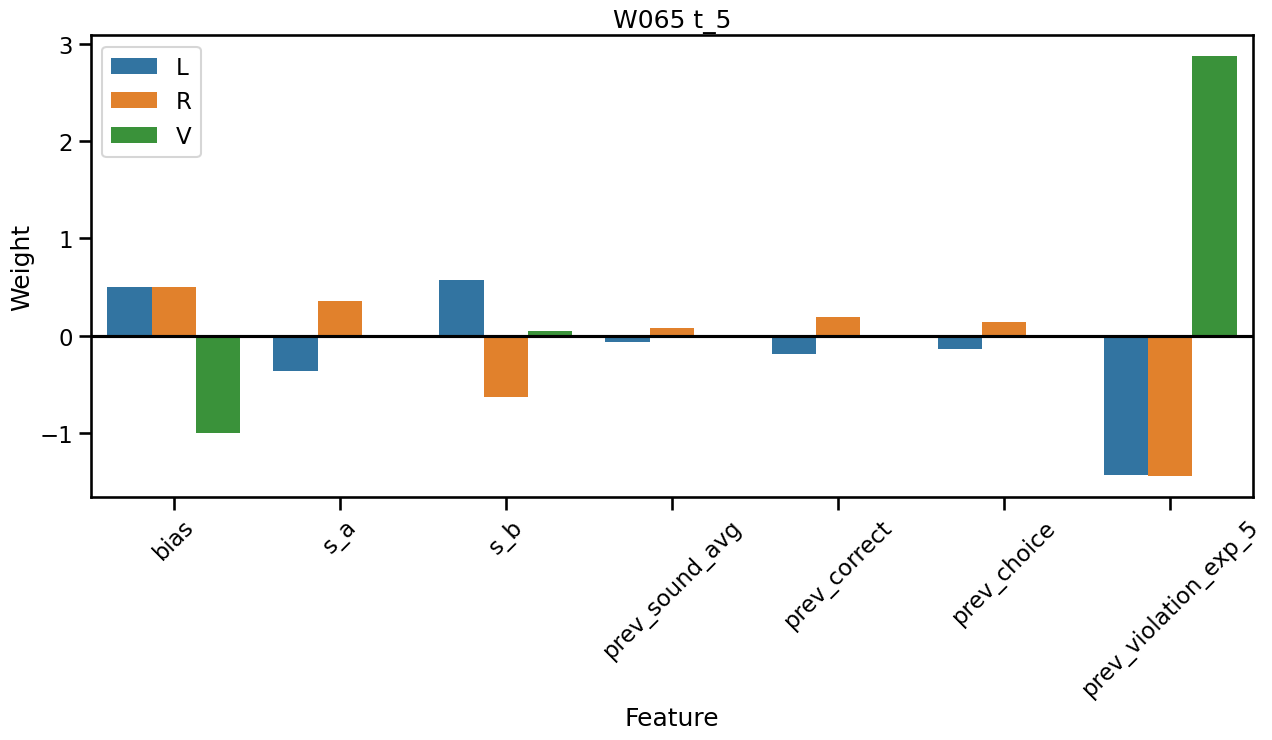

In [69]:
full_experiment.plot_class_weights(animal_id="W065", model_name="t_5")